In [1]:
#Created for NISE
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import imageio
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from data_utils import FacePlacedData, ClusterRandomSampler
import time
import os
from PIL import Image
import cv2
from functions import opening_transform, pass_img, get_blobs, get_faces

%load_ext autoreload
# %autoreload 2
%matplotlib inline
torch.cuda.empty_cache()
plt.ion()   # interactive mode

Data size: 109600
Img size:  torch.Size([3, 240, 320])
Segmentation size:  torch.Size([240, 320])


<Figure size 720x720 with 0 Axes>

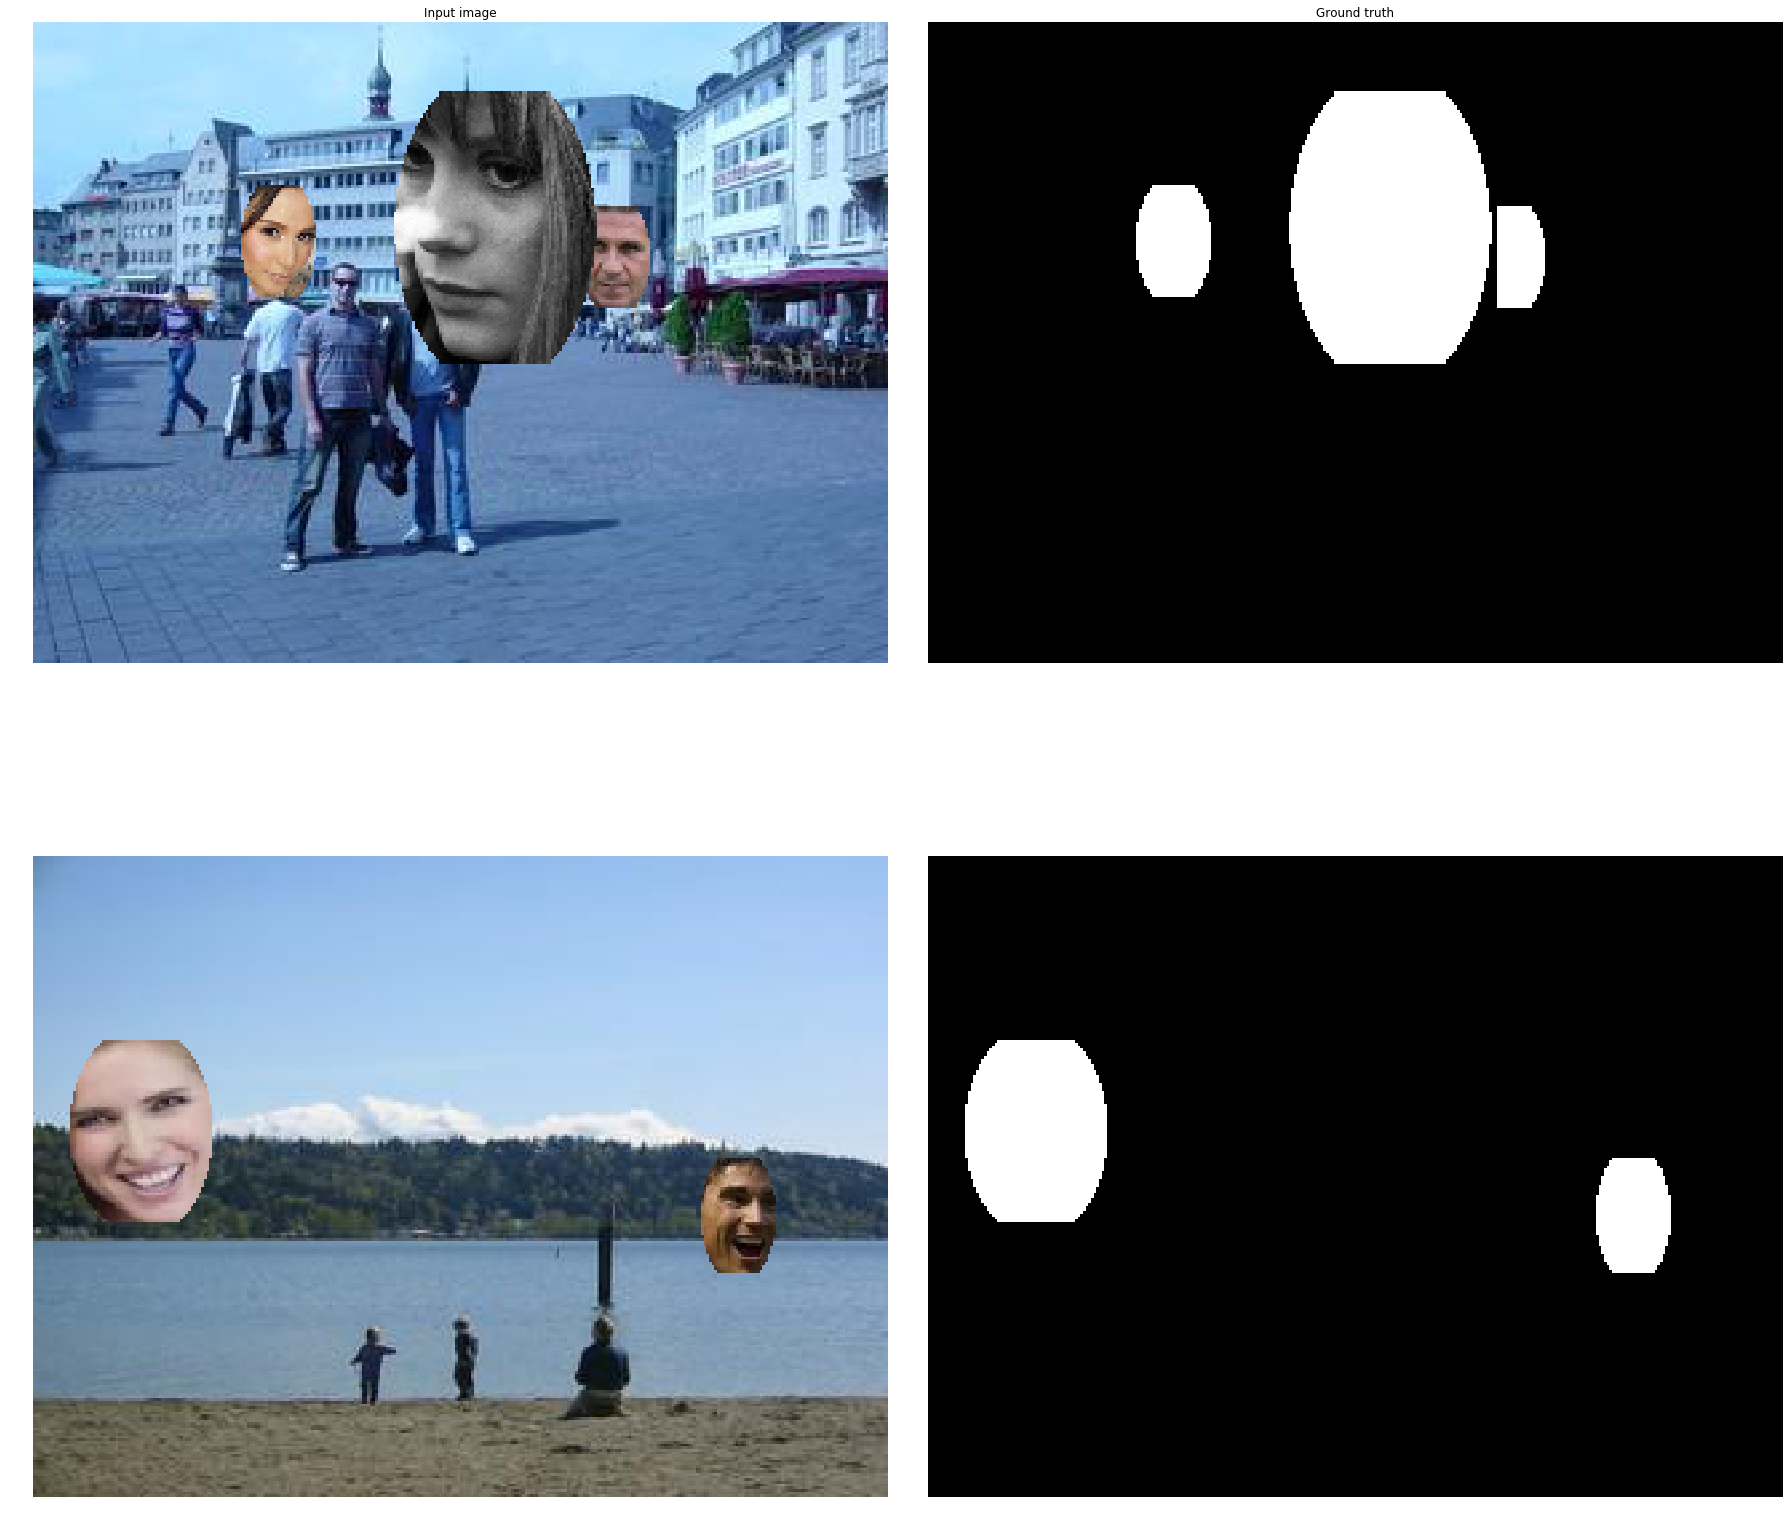

In [2]:
data = FacePlacedData(image_paths_file='data/face_placed_list.txt')
print("Data size: %i" % len(data))
print("Img size: ", data[0][0].size())
print("Segmentation size: ", data[0][1].size())

num_example_imgs = 2
plt.figure(figsize=(10, 5 * num_example_imgs))
fig, ax = plt.subplots(2, 2, figsize=(25, 25))
ax[0, 0].imshow(data[60][0].numpy().transpose(1,2,0))
ax[0, 0].axis('off')
ax[0, 0].set_title("Input image")

ax[0, 1].imshow(data[60][1].numpy().squeeze(), cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('Ground truth')

ax[1, 0].imshow(data[201][0].numpy().transpose(1,2,0))
ax[1, 0].axis('off')

ax[1, 1].imshow(data[201][1].numpy().squeeze(), cmap='gray')
ax[1, 1].axis('off')

plt.tight_layout()

In [3]:
torch.manual_seed(777)
train_data, val_data, test_data = torch.utils.data.random_split(data, [int(len(data)*0.8), int(len(data)*0.1), int(len(data)*0.1)])
print("Training data size: %i" % len(train_data))
print("Validation data size: %i" % len(val_data))
print("Test data size: %i" % len(test_data))

Training data size: 87680
Validation data size: 10960
Test data size: 10960


In [ ]:
# from nets.face_seg_nn import FaceSegNN
# from solver2 import Solver
# import torch.nn.functional as F
# import torchvision.models as models
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=8,
#                                            shuffle=True,
#                                            num_workers=2)
# val_loader = torch.utils.data.DataLoader(val_data,
#                                          batch_size=8,
#                                          shuffle=False,
#                                          num_workers=2)
# model = FaceSegNN()
# model.cuda()
# print(len(list(model.parameters())))

# #or param in list(model.parameters()):
# #    param.requires_grad = False    

# solver = Solver(optim_args={"lr": 1e-3,
#                             "eps": 1e-8
#                             },
#                 loss_func = torch.nn.CrossEntropyLoss())
# solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1



# import pandas as pd
# save_acc_loss_dic = {'train_loss_history': solver.train_loss_history,
#                      'train_acc_history' : solver.train_acc_history ,
#                      'val_acc_history'   : solver.val_acc_history   ,
#                      'val_loss_history'  : solver.val_loss_history   }

# save_acc_loss = pd.DataFrame(data = save_acc_loss_dic)
# save_acc_loss.to_csv('save_acc_loss.txt')

In [4]:
from nets.face_seg_nn import FaceSegNN
from nets.face_fcn_nn import fcn32s
from nets.face_fcn_nn2 import FCN8s
from solver2 import Solver
import torch.nn.functional as F
import torchvision.models as models
import pickle
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=8,
#                                            shuffle=True,
#                                            num_workers=2)
# val_loader = torch.utils.data.DataLoader(val_data,
#                                          batch_size=2,
#                                          shuffle=False,
#                                          num_workers=2)
model = FaceSegNN(n_classes=2)
# model = torch.load('train_model_epoch_0')
model.cuda()
print(len(list(model.parameters()))) 

solver = Solver(optim_args={"lr": 1e-4,
                            "eps": 1e-6
                            },
                loss_func = torch.nn.CrossEntropyLoss())
len_data = len(train_data)
len_val = len(val_data)
count_data = 0
num_sub = 50
len_split = len_data // num_sub
val_split = len_val // num_sub
for i in range(200):
    sub_val = torch.utils.data.Subset(val_data, np.arange(i*int(len_val*(1/num_sub)), (i+1)*int(len_val*(1/num_sub))))
    sub_data = torch.utils.data.Subset(train_data, np.arange(i*int(len_data*(1/num_sub)), (i+1)*int(len_data*(1/num_sub))))
    train_loader = torch.utils.data.DataLoader(sub_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=2)
    val_loader = torch.utils.data.DataLoader(sub_val,
                                         batch_size=2,
                                         shuffle=False,
                                         num_workers=2)
    if i % num_sub == 0:
        count_data = 0
    else:
        count_data += len_split
                                                          
    if i == 0:
        solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1)
    else:
        solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1, reset_hist = False)
    print ("Out of solver")
    model.save('train_segnet_model_subepoch_'+str(i))
    


    save_acc_loss_dic = {'train_loss_history': solver.train_loss_history,
                         'train_acc_history' : solver.train_acc_history ,
                         'val_acc_history'   : solver.val_acc_history   ,
                         'val_loss_history'  : solver.val_loss_history   }

    # print(save_acc_loss_dic)
    # # save_acc_loss = pd.DataFrame(data = save_acc_loss_dic)
    # # save_acc_loss.to_csv()
    with open('save_segnet_acc_loss_' + str(i) + '.pkl', 'wb') as handle:
        pickle.dump(save_acc_loss_dic, handle)


104
START TRAIN.
[Iteration 1/220] TRAIN loss: 0.75805246829986572266
[Iteration 2/220] TRAIN loss: 0.72863751649856567383
[Iteration 3/220] TRAIN loss: 0.72455734014511108398
[Iteration 4/220] TRAIN loss: 0.71659928560256958008
[Iteration 5/220] TRAIN loss: 0.71751213073730468750
[Iteration 6/220] TRAIN loss: 0.71719354391098022461
[Iteration 7/220] TRAIN loss: 0.71715182065963745117
[Iteration 8/220] TRAIN loss: 0.71560961008071899414
[Iteration 9/220] TRAIN loss: 0.70757675170898437500
[Iteration 10/220] TRAIN loss: 0.71420872211456298828
[Iteration 11/220] TRAIN loss: 0.70805299282073974609
[Iteration 12/220] TRAIN loss: 0.70984899997711181641
[Iteration 13/220] TRAIN loss: 0.70527327060699462891
[Iteration 14/220] TRAIN loss: 0.70943164825439453125
[Iteration 15/220] TRAIN loss: 0.70890557765960693359
[Iteration 16/220] TRAIN loss: 0.70518040657043457031
[Iteration 17/220] TRAIN loss: 0.70446515083312988281
[Iteration 18/220] TRAIN loss: 0.71033418178558349609
[Iteration 19/220] T

[Iteration 152/220] TRAIN loss: 0.62069547176361083984
[Iteration 153/220] TRAIN loss: 0.62816971540451049805
[Iteration 154/220] TRAIN loss: 0.62693333625793457031
[Iteration 155/220] TRAIN loss: 0.62599998712539672852
[Iteration 156/220] TRAIN loss: 0.61094188690185546875
[Iteration 157/220] TRAIN loss: 0.62171238660812377930
[Iteration 158/220] TRAIN loss: 0.61583787202835083008
[Iteration 159/220] TRAIN loss: 0.62044274806976318359
[Iteration 160/220] TRAIN loss: 0.60584241151809692383
[Iteration 161/220] TRAIN loss: 0.62461358308792114258
[Iteration 162/220] TRAIN loss: 0.60570436716079711914
[Iteration 163/220] TRAIN loss: 0.61330807209014892578
[Iteration 164/220] TRAIN loss: 0.60717666149139404297
[Iteration 165/220] TRAIN loss: 0.63020271062850952148
[Iteration 166/220] TRAIN loss: 0.60536211729049682617
[Iteration 167/220] TRAIN loss: 0.61307764053344726562
[Iteration 168/220] TRAIN loss: 0.59944385290145874023
[Iteration 169/220] TRAIN loss: 0.61714255809783935547
[Iteration

[Iteration 80/220] TRAIN loss: 0.58005952835083007812
[Iteration 81/220] TRAIN loss: 0.56838315725326538086
[Iteration 82/220] TRAIN loss: 0.56542801856994628906
[Iteration 83/220] TRAIN loss: 0.56546854972839355469
[Iteration 84/220] TRAIN loss: 0.58449578285217285156
[Iteration 85/220] TRAIN loss: 0.57512032985687255859
[Iteration 86/220] TRAIN loss: 0.56793659925460815430
[Iteration 87/220] TRAIN loss: 0.56227016448974609375
[Iteration 88/220] TRAIN loss: 0.58211034536361694336
[Iteration 89/220] TRAIN loss: 0.56359809637069702148
[Iteration 90/220] TRAIN loss: 0.58509659767150878906
[Iteration 91/220] TRAIN loss: 0.56320458650588989258
[Iteration 92/220] TRAIN loss: 0.57247668504714965820
[Iteration 93/220] TRAIN loss: 0.55849707126617431641
[Iteration 94/220] TRAIN loss: 0.58878910541534423828
[Iteration 95/220] TRAIN loss: 0.56247937679290771484
[Iteration 96/220] TRAIN loss: 0.56283444166183471680
[Iteration 97/220] TRAIN loss: 0.55414789915084838867
[Iteration 98/220] TRAIN los

[Iteration 7/220] TRAIN loss: 0.55461096763610839844
[Iteration 8/220] TRAIN loss: 0.54416769742965698242
[Iteration 9/220] TRAIN loss: 0.54577893018722534180
[Iteration 10/220] TRAIN loss: 0.55567991733551025391
[Iteration 11/220] TRAIN loss: 0.54236334562301635742
[Iteration 12/220] TRAIN loss: 0.54924488067626953125
[Iteration 13/220] TRAIN loss: 0.54424232244491577148
[Iteration 14/220] TRAIN loss: 0.54847806692123413086
[Iteration 15/220] TRAIN loss: 0.56203544139862060547
[Iteration 16/220] TRAIN loss: 0.55437707901000976562
[Iteration 17/220] TRAIN loss: 0.53790730237960815430
[Iteration 18/220] TRAIN loss: 0.56470364332199096680
[Iteration 19/220] TRAIN loss: 0.54664558172225952148
[Iteration 20/220] TRAIN loss: 0.54836153984069824219
[Iteration 21/220] TRAIN loss: 0.54154479503631591797
[Iteration 22/220] TRAIN loss: 0.55263936519622802734
[Iteration 23/220] TRAIN loss: 0.58122032880783081055
[Iteration 24/220] TRAIN loss: 0.54749274253845214844
[Iteration 25/220] TRAIN loss: 

[Iteration 158/220] TRAIN loss: 0.53144651651382446289
[Iteration 159/220] TRAIN loss: 0.54530519247055053711
[Iteration 160/220] TRAIN loss: 0.53122448921203613281
[Iteration 161/220] TRAIN loss: 0.53193396329879760742
[Iteration 162/220] TRAIN loss: 0.57884681224822998047
[Iteration 163/220] TRAIN loss: 0.53543978929519653320
[Iteration 164/220] TRAIN loss: 0.53975868225097656250
[Iteration 165/220] TRAIN loss: 0.53171449899673461914
[Iteration 166/220] TRAIN loss: 0.53574794530868530273
[Iteration 167/220] TRAIN loss: 0.53617542982101440430
[Iteration 168/220] TRAIN loss: 0.53353768587112426758
[Iteration 169/220] TRAIN loss: 0.55669122934341430664
[Iteration 170/220] TRAIN loss: 0.54514712095260620117
[Iteration 171/220] TRAIN loss: 0.54249119758605957031
[Iteration 172/220] TRAIN loss: 0.54119580984115600586
[Iteration 173/220] TRAIN loss: 0.54250580072402954102
[Iteration 174/220] TRAIN loss: 0.53588020801544189453
[Iteration 175/220] TRAIN loss: 0.54143530130386352539
[Iteration

[Iteration 86/220] TRAIN loss: 0.51705354452133178711
[Iteration 87/220] TRAIN loss: 0.53522098064422607422
[Iteration 88/220] TRAIN loss: 0.53000086545944213867
[Iteration 89/220] TRAIN loss: 0.52563989162445068359
[Iteration 90/220] TRAIN loss: 0.53559458255767822266
[Iteration 91/220] TRAIN loss: 0.51877605915069580078
[Iteration 92/220] TRAIN loss: 0.54808157682418823242
[Iteration 93/220] TRAIN loss: 0.52807170152664184570
[Iteration 94/220] TRAIN loss: 0.52629077434539794922
[Iteration 95/220] TRAIN loss: 0.53745609521865844727
[Iteration 96/220] TRAIN loss: 0.52496284246444702148
[Iteration 97/220] TRAIN loss: 0.53555566072463989258
[Iteration 98/220] TRAIN loss: 0.53439962863922119141
[Iteration 99/220] TRAIN loss: 0.53325557708740234375
[Iteration 100/220] TRAIN loss: 0.52714037895202636719
[Iteration 101/220] TRAIN loss: 0.52028310298919677734
[Iteration 102/220] TRAIN loss: 0.52832019329071044922
[Iteration 103/220] TRAIN loss: 0.52204316854476928711
[Iteration 104/220] TRAI

[Iteration 13/220] TRAIN loss: 0.51977765560150146484
[Iteration 14/220] TRAIN loss: 0.52205234766006469727
[Iteration 15/220] TRAIN loss: 0.51301759481430053711
[Iteration 16/220] TRAIN loss: 0.52113288640975952148
[Iteration 17/220] TRAIN loss: 0.50826698541641235352
[Iteration 18/220] TRAIN loss: 0.51177686452865600586
[Iteration 19/220] TRAIN loss: 0.50628632307052612305
[Iteration 20/220] TRAIN loss: 0.52973908185958862305
[Iteration 21/220] TRAIN loss: 0.52666324377059936523
[Iteration 22/220] TRAIN loss: 0.51250684261322021484
[Iteration 23/220] TRAIN loss: 0.50755119323730468750
[Iteration 24/220] TRAIN loss: 0.52352398633956909180
[Iteration 25/220] TRAIN loss: 0.52303904294967651367
[Iteration 26/220] TRAIN loss: 0.51073336601257324219
[Iteration 27/220] TRAIN loss: 0.50697737932205200195
[Iteration 28/220] TRAIN loss: 0.52230954170227050781
[Iteration 29/220] TRAIN loss: 0.51524746417999267578
[Iteration 30/220] TRAIN loss: 0.51037555932998657227
[Iteration 31/220] TRAIN los

[Iteration 164/220] TRAIN loss: 0.49345606565475463867
[Iteration 165/220] TRAIN loss: 0.50946348905563354492
[Iteration 166/220] TRAIN loss: 0.51646810770034790039
[Iteration 167/220] TRAIN loss: 0.49537250399589538574
[Iteration 168/220] TRAIN loss: 0.50868725776672363281
[Iteration 169/220] TRAIN loss: 0.50192677974700927734
[Iteration 170/220] TRAIN loss: 0.51752436161041259766
[Iteration 171/220] TRAIN loss: 0.49059128761291503906
[Iteration 172/220] TRAIN loss: 0.52863895893096923828
[Iteration 173/220] TRAIN loss: 0.51132994890213012695
[Iteration 174/220] TRAIN loss: 0.51981890201568603516
[Iteration 175/220] TRAIN loss: 0.50146049261093139648
[Iteration 176/220] TRAIN loss: 0.49762120842933654785
[Iteration 177/220] TRAIN loss: 0.51047331094741821289
[Iteration 178/220] TRAIN loss: 0.50736111402511596680
[Iteration 179/220] TRAIN loss: 0.50900065898895263672
[Iteration 180/220] TRAIN loss: 0.52246493101119995117
[Iteration 181/220] TRAIN loss: 0.49929484724998474121
[Iteration

[Iteration 92/220] TRAIN loss: 0.50132769346237182617
[Iteration 93/220] TRAIN loss: 0.49639856815338134766
[Iteration 94/220] TRAIN loss: 0.51996213197708129883
[Iteration 95/220] TRAIN loss: 0.49677246809005737305
[Iteration 96/220] TRAIN loss: 0.49473458528518676758
[Iteration 97/220] TRAIN loss: 0.50029683113098144531
[Iteration 98/220] TRAIN loss: 0.49884408712387084961
[Iteration 99/220] TRAIN loss: 0.50932949781417846680
[Iteration 100/220] TRAIN loss: 0.50835466384887695312
[Iteration 101/220] TRAIN loss: 0.50729173421859741211
[Iteration 102/220] TRAIN loss: 0.49671071767807006836
[Iteration 103/220] TRAIN loss: 0.50234544277191162109
[Iteration 104/220] TRAIN loss: 0.49767100811004638672
[Iteration 105/220] TRAIN loss: 0.52619910240173339844
[Iteration 106/220] TRAIN loss: 0.49825429916381835938
[Iteration 107/220] TRAIN loss: 0.49029541015625000000
[Iteration 108/220] TRAIN loss: 0.49876984953880310059
[Iteration 109/220] TRAIN loss: 0.49882191419601440430
[Iteration 110/220

[Iteration 19/220] TRAIN loss: 0.48931461572647094727
[Iteration 20/220] TRAIN loss: 0.49660065770149230957
[Iteration 21/220] TRAIN loss: 0.50380057096481323242
[Iteration 22/220] TRAIN loss: 0.49177896976470947266
[Iteration 23/220] TRAIN loss: 0.49973288178443908691
[Iteration 24/220] TRAIN loss: 0.50682008266448974609
[Iteration 25/220] TRAIN loss: 0.50489205121994018555
[Iteration 26/220] TRAIN loss: 0.49449875950813293457
[Iteration 27/220] TRAIN loss: 0.50612229108810424805
[Iteration 28/220] TRAIN loss: 0.48485830426216125488
[Iteration 29/220] TRAIN loss: 0.48942917585372924805
[Iteration 30/220] TRAIN loss: 0.49034652113914489746
[Iteration 31/220] TRAIN loss: 0.48599457740783691406
[Iteration 32/220] TRAIN loss: 0.48985332250595092773
[Iteration 33/220] TRAIN loss: 0.47774311900138854980
[Iteration 34/220] TRAIN loss: 0.50460118055343627930
[Iteration 35/220] TRAIN loss: 0.48476576805114746094
[Iteration 36/220] TRAIN loss: 0.50985318422317504883
[Iteration 37/220] TRAIN los

[Iteration 170/220] TRAIN loss: 0.48020005226135253906
[Iteration 171/220] TRAIN loss: 0.48071619868278503418
[Iteration 172/220] TRAIN loss: 0.48991805315017700195
[Iteration 173/220] TRAIN loss: 0.48431631922721862793
[Iteration 174/220] TRAIN loss: 0.48518133163452148438
[Iteration 175/220] TRAIN loss: 0.48483988642692565918
[Iteration 176/220] TRAIN loss: 0.47342601418495178223
[Iteration 177/220] TRAIN loss: 0.48329499363899230957
[Iteration 178/220] TRAIN loss: 0.47724252939224243164
[Iteration 179/220] TRAIN loss: 0.47475859522819519043
[Iteration 180/220] TRAIN loss: 0.49518886208534240723
[Iteration 181/220] TRAIN loss: 0.47365072369575500488
[Iteration 182/220] TRAIN loss: 0.49887803196907043457
[Iteration 183/220] TRAIN loss: 0.48573714494705200195
[Iteration 184/220] TRAIN loss: 0.47021901607513427734
[Iteration 185/220] TRAIN loss: 0.48773589730262756348
[Iteration 186/220] TRAIN loss: 0.48676359653472900391
[Iteration 187/220] TRAIN loss: 0.48792815208435058594
[Iteration

[Iteration 98/220] TRAIN loss: 0.49415409564971923828
[Iteration 99/220] TRAIN loss: 0.49624699354171752930
[Iteration 100/220] TRAIN loss: 0.49645537137985229492
[Iteration 101/220] TRAIN loss: 0.48128762841224670410
[Iteration 102/220] TRAIN loss: 0.46370860934257507324
[Iteration 103/220] TRAIN loss: 0.48922353982925415039
[Iteration 104/220] TRAIN loss: 0.47684854269027709961
[Iteration 105/220] TRAIN loss: 0.46957591176033020020
[Iteration 106/220] TRAIN loss: 0.48049727082252502441
[Iteration 107/220] TRAIN loss: 0.49183094501495361328
[Iteration 108/220] TRAIN loss: 0.47801366448402404785
[Iteration 109/220] TRAIN loss: 0.46877324581146240234
[Iteration 110/220] TRAIN loss: 0.49267724156379699707
[Iteration 111/220] TRAIN loss: 0.48166814446449279785
[Iteration 112/220] TRAIN loss: 0.47531804442405700684
[Iteration 113/220] TRAIN loss: 0.47487717866897583008
[Iteration 114/220] TRAIN loss: 0.46996796131134033203
[Iteration 115/220] TRAIN loss: 0.48202347755432128906
[Iteration 1

[Iteration 25/220] TRAIN loss: 0.49142965674400329590
[Iteration 26/220] TRAIN loss: 0.46272537112236022949
[Iteration 27/220] TRAIN loss: 0.47954517602920532227
[Iteration 28/220] TRAIN loss: 0.47773498296737670898
[Iteration 29/220] TRAIN loss: 0.47551405429840087891
[Iteration 30/220] TRAIN loss: 0.48606964945793151855
[Iteration 31/220] TRAIN loss: 0.46398431062698364258
[Iteration 32/220] TRAIN loss: 0.47382074594497680664
[Iteration 33/220] TRAIN loss: 0.49912011623382568359
[Iteration 34/220] TRAIN loss: 0.46195644140243530273
[Iteration 35/220] TRAIN loss: 0.49629124999046325684
[Iteration 36/220] TRAIN loss: 0.45888283848762512207
[Iteration 37/220] TRAIN loss: 0.48762959241867065430
[Iteration 38/220] TRAIN loss: 0.46488001942634582520
[Iteration 39/220] TRAIN loss: 0.48374873399734497070
[Iteration 40/220] TRAIN loss: 0.46548080444335937500
[Iteration 41/220] TRAIN loss: 0.47151851654052734375
[Iteration 42/220] TRAIN loss: 0.47418472170829772949
[Iteration 43/220] TRAIN los

[Iteration 176/220] TRAIN loss: 0.47642740607261657715
[Iteration 177/220] TRAIN loss: 0.45158299803733825684
[Iteration 178/220] TRAIN loss: 0.47662568092346191406
[Iteration 179/220] TRAIN loss: 0.47512930631637573242
[Iteration 180/220] TRAIN loss: 0.46479314565658569336
[Iteration 181/220] TRAIN loss: 0.45717492699623107910
[Iteration 182/220] TRAIN loss: 0.46518814563751220703
[Iteration 183/220] TRAIN loss: 0.46597346663475036621
[Iteration 184/220] TRAIN loss: 0.46887788176536560059
[Iteration 185/220] TRAIN loss: 0.46356984972953796387
[Iteration 186/220] TRAIN loss: 0.46114161610603332520
[Iteration 187/220] TRAIN loss: 0.47877943515777587891
[Iteration 188/220] TRAIN loss: 0.46456974744796752930
[Iteration 189/220] TRAIN loss: 0.45331457257270812988
[Iteration 190/220] TRAIN loss: 0.46757760643959045410
[Iteration 191/220] TRAIN loss: 0.44633626937866210938
[Iteration 192/220] TRAIN loss: 0.48281279206275939941
[Iteration 193/220] TRAIN loss: 0.46429571509361267090
[Iteration

[Iteration 104/220] TRAIN loss: 0.47817915678024291992
[Iteration 105/220] TRAIN loss: 0.46462300419807434082
[Iteration 106/220] TRAIN loss: 0.45751368999481201172
[Iteration 107/220] TRAIN loss: 0.45461294054985046387
[Iteration 108/220] TRAIN loss: 0.45523473620414733887
[Iteration 109/220] TRAIN loss: 0.45677164196968078613
[Iteration 110/220] TRAIN loss: 0.44083771109580993652
[Iteration 111/220] TRAIN loss: 0.44845539331436157227
[Iteration 112/220] TRAIN loss: 0.45872059464454650879
[Iteration 113/220] TRAIN loss: 0.46184408664703369141
[Iteration 114/220] TRAIN loss: 0.45284277200698852539
[Iteration 115/220] TRAIN loss: 0.44596734642982482910
[Iteration 116/220] TRAIN loss: 0.45246410369873046875
[Iteration 117/220] TRAIN loss: 0.48309427499771118164
[Iteration 118/220] TRAIN loss: 0.46452468633651733398
[Iteration 119/220] TRAIN loss: 0.46354734897613525391
[Iteration 120/220] TRAIN loss: 0.45374411344528198242
[Iteration 121/220] TRAIN loss: 0.44662705063819885254
[Iteration

[Iteration 31/220] TRAIN loss: 0.43470606207847595215
[Iteration 32/220] TRAIN loss: 0.45570698380470275879
[Iteration 33/220] TRAIN loss: 0.45802342891693115234
[Iteration 34/220] TRAIN loss: 0.47420179843902587891
[Iteration 35/220] TRAIN loss: 0.44878825545310974121
[Iteration 36/220] TRAIN loss: 0.45627248287200927734
[Iteration 37/220] TRAIN loss: 0.46036747097969055176
[Iteration 38/220] TRAIN loss: 0.46383970975875854492
[Iteration 39/220] TRAIN loss: 0.43972751498222351074
[Iteration 40/220] TRAIN loss: 0.44722861051559448242
[Iteration 41/220] TRAIN loss: 0.45269384980201721191
[Iteration 42/220] TRAIN loss: 0.45729598402976989746
[Iteration 43/220] TRAIN loss: 0.45978331565856933594
[Iteration 44/220] TRAIN loss: 0.43757516145706176758
[Iteration 45/220] TRAIN loss: 0.44721430540084838867
[Iteration 46/220] TRAIN loss: 0.43125209212303161621
[Iteration 47/220] TRAIN loss: 0.46527552604675292969
[Iteration 48/220] TRAIN loss: 0.46043574810028076172
[Iteration 49/220] TRAIN los

[Iteration 182/220] TRAIN loss: 0.45217350125312805176
[Iteration 183/220] TRAIN loss: 0.44119825959205627441
[Iteration 184/220] TRAIN loss: 0.44593352079391479492
[Iteration 185/220] TRAIN loss: 0.44417369365692138672
[Iteration 186/220] TRAIN loss: 0.45191588997840881348
[Iteration 187/220] TRAIN loss: 0.45826244354248046875
[Iteration 188/220] TRAIN loss: 0.43596425652503967285
[Iteration 189/220] TRAIN loss: 0.45855712890625000000
[Iteration 190/220] TRAIN loss: 0.43276551365852355957
[Iteration 191/220] TRAIN loss: 0.43648219108581542969
[Iteration 192/220] TRAIN loss: 0.45013275742530822754
[Iteration 193/220] TRAIN loss: 0.44481042027473449707
[Iteration 194/220] TRAIN loss: 0.43783685564994812012
[Iteration 195/220] TRAIN loss: 0.43596780300140380859
[Iteration 196/220] TRAIN loss: 0.44693577289581298828
[Iteration 197/220] TRAIN loss: 0.42906209826469421387
[Iteration 198/220] TRAIN loss: 0.45971772074699401855
[Iteration 199/220] TRAIN loss: 0.44714009761810302734
[Iteration

[Iteration 110/220] TRAIN loss: 0.45501357316970825195
[Iteration 111/220] TRAIN loss: 0.42619907855987548828
[Iteration 112/220] TRAIN loss: 0.45843642950057983398
[Iteration 113/220] TRAIN loss: 0.42654651403427124023
[Iteration 114/220] TRAIN loss: 0.43214407563209533691
[Iteration 115/220] TRAIN loss: 0.42221024632453918457
[Iteration 116/220] TRAIN loss: 0.43145462870597839355
[Iteration 117/220] TRAIN loss: 0.45280811190605163574
[Iteration 118/220] TRAIN loss: 0.43576538562774658203
[Iteration 119/220] TRAIN loss: 0.45503616333007812500
[Iteration 120/220] TRAIN loss: 0.43521168828010559082
[Iteration 121/220] TRAIN loss: 0.43908849358558654785
[Iteration 122/220] TRAIN loss: 0.44578075408935546875
[Iteration 123/220] TRAIN loss: 0.45660796761512756348
[Iteration 124/220] TRAIN loss: 0.42909643054008483887
[Iteration 125/220] TRAIN loss: 0.45165592432022094727
[Iteration 126/220] TRAIN loss: 0.44950440526008605957
[Iteration 127/220] TRAIN loss: 0.43975475430488586426
[Iteration

[Iteration 37/220] TRAIN loss: 0.43657913804054260254
[Iteration 38/220] TRAIN loss: 0.44954550266265869141
[Iteration 39/220] TRAIN loss: 0.42027968168258666992
[Iteration 40/220] TRAIN loss: 0.44019952416419982910
[Iteration 41/220] TRAIN loss: 0.42472320795059204102
[Iteration 42/220] TRAIN loss: 0.43633666634559631348
[Iteration 43/220] TRAIN loss: 0.44197383522987365723
[Iteration 44/220] TRAIN loss: 0.43365731835365295410
[Iteration 45/220] TRAIN loss: 0.42618206143379211426
[Iteration 46/220] TRAIN loss: 0.42807048559188842773
[Iteration 47/220] TRAIN loss: 0.43318247795104980469
[Iteration 48/220] TRAIN loss: 0.45315372943878173828
[Iteration 49/220] TRAIN loss: 0.46067234873771667480
[Iteration 50/220] TRAIN loss: 0.42702534794807434082
[Iteration 51/220] TRAIN loss: 0.44639226794242858887
[Iteration 52/220] TRAIN loss: 0.42774185538291931152
[Iteration 53/220] TRAIN loss: 0.41058728098869323730
[Iteration 54/220] TRAIN loss: 0.44391870498657226562
[Iteration 55/220] TRAIN los

[Iteration 188/220] TRAIN loss: 0.44340386986732482910
[Iteration 189/220] TRAIN loss: 0.45697864890098571777
[Iteration 190/220] TRAIN loss: 0.43330255150794982910
[Iteration 191/220] TRAIN loss: 0.42693752050399780273
[Iteration 192/220] TRAIN loss: 0.42144897580146789551
[Iteration 193/220] TRAIN loss: 0.44070118665695190430
[Iteration 194/220] TRAIN loss: 0.43404820561408996582
[Iteration 195/220] TRAIN loss: 0.42692905664443969727
[Iteration 196/220] TRAIN loss: 0.43352070450782775879
[Iteration 197/220] TRAIN loss: 0.42143115401268005371
[Iteration 198/220] TRAIN loss: 0.44543552398681640625
[Iteration 199/220] TRAIN loss: 0.40979665517807006836
[Iteration 200/220] TRAIN loss: 0.43483728170394897461
[Iteration 201/220] TRAIN loss: 0.40486779808998107910
[Iteration 202/220] TRAIN loss: 0.44545277953147888184
[Iteration 203/220] TRAIN loss: 0.43410205841064453125
[Iteration 204/220] TRAIN loss: 0.42187032103538513184
[Iteration 205/220] TRAIN loss: 0.41304785013198852539
[Iteration

[Iteration 116/220] TRAIN loss: 0.41815003752708435059
[Iteration 117/220] TRAIN loss: 0.42044591903686523438
[Iteration 118/220] TRAIN loss: 0.41027685999870300293
[Iteration 119/220] TRAIN loss: 0.41528710722923278809
[Iteration 120/220] TRAIN loss: 0.41697424650192260742
[Iteration 121/220] TRAIN loss: 0.43060973286628723145
[Iteration 122/220] TRAIN loss: 0.43932831287384033203
[Iteration 123/220] TRAIN loss: 0.42357352375984191895
[Iteration 124/220] TRAIN loss: 0.43247786164283752441
[Iteration 125/220] TRAIN loss: 0.40249770879745483398
[Iteration 126/220] TRAIN loss: 0.41846576333045959473
[Iteration 127/220] TRAIN loss: 0.41398283839225769043
[Iteration 128/220] TRAIN loss: 0.42300668358802795410
[Iteration 129/220] TRAIN loss: 0.39535501599311828613
[Iteration 130/220] TRAIN loss: 0.40480190515518188477
[Iteration 131/220] TRAIN loss: 0.42623209953308105469
[Iteration 132/220] TRAIN loss: 0.40199401974678039551
[Iteration 133/220] TRAIN loss: 0.40478038787841796875
[Iteration

[Iteration 43/220] TRAIN loss: 0.42474374175071716309
[Iteration 44/220] TRAIN loss: 0.40851178765296936035
[Iteration 45/220] TRAIN loss: 0.41212728619575500488
[Iteration 46/220] TRAIN loss: 0.40057840943336486816
[Iteration 47/220] TRAIN loss: 0.43215534090995788574
[Iteration 48/220] TRAIN loss: 0.41412445902824401855
[Iteration 49/220] TRAIN loss: 0.42395442724227905273
[Iteration 50/220] TRAIN loss: 0.42470398545265197754
[Iteration 51/220] TRAIN loss: 0.41552412509918212891
[Iteration 52/220] TRAIN loss: 0.40797808766365051270
[Iteration 53/220] TRAIN loss: 0.39938735961914062500
[Iteration 54/220] TRAIN loss: 0.39679250121116638184
[Iteration 55/220] TRAIN loss: 0.41234171390533447266
[Iteration 56/220] TRAIN loss: 0.41170576214790344238
[Iteration 57/220] TRAIN loss: 0.43244770169258117676
[Iteration 58/220] TRAIN loss: 0.41129553318023681641
[Iteration 59/220] TRAIN loss: 0.40422776341438293457
[Iteration 60/220] TRAIN loss: 0.42058843374252319336
[Iteration 61/220] TRAIN los

[Iteration 193/220] TRAIN loss: 0.42631608247756958008
[Iteration 194/220] TRAIN loss: 0.39520877599716186523
[Iteration 195/220] TRAIN loss: 0.38958325982093811035
[Iteration 196/220] TRAIN loss: 0.40572279691696166992
[Iteration 197/220] TRAIN loss: 0.41625064611434936523
[Iteration 198/220] TRAIN loss: 0.42048048973083496094
[Iteration 199/220] TRAIN loss: 0.40379521250724792480
[Iteration 200/220] TRAIN loss: 0.42599844932556152344
[Iteration 201/220] TRAIN loss: 0.42095124721527099609
[Iteration 202/220] TRAIN loss: 0.41892212629318237305
[Iteration 203/220] TRAIN loss: 0.40045949816703796387
[Iteration 204/220] TRAIN loss: 0.41975191235542297363
[Iteration 205/220] TRAIN loss: 0.41331440210342407227
[Iteration 206/220] TRAIN loss: 0.42395126819610595703
[Iteration 207/220] TRAIN loss: 0.41185578703880310059
[Iteration 208/220] TRAIN loss: 0.40586599707603454590
[Iteration 209/220] TRAIN loss: 0.42010572552680969238
[Iteration 210/220] TRAIN loss: 0.42422860860824584961
[Iteration

[Iteration 121/220] TRAIN loss: 0.40780007839202880859
[Iteration 122/220] TRAIN loss: 0.39922744035720825195
[Iteration 123/220] TRAIN loss: 0.40716421604156494141
[Iteration 124/220] TRAIN loss: 0.39576056599617004395
[Iteration 125/220] TRAIN loss: 0.40313485264778137207
[Iteration 126/220] TRAIN loss: 0.39814412593841552734
[Iteration 127/220] TRAIN loss: 0.40966922044754028320
[Iteration 128/220] TRAIN loss: 0.41110560297966003418
[Iteration 129/220] TRAIN loss: 0.41428005695343017578
[Iteration 130/220] TRAIN loss: 0.40108942985534667969
[Iteration 131/220] TRAIN loss: 0.40209686756134033203
[Iteration 132/220] TRAIN loss: 0.40418121218681335449
[Iteration 133/220] TRAIN loss: 0.39596241712570190430
[Iteration 134/220] TRAIN loss: 0.39850145578384399414
[Iteration 135/220] TRAIN loss: 0.39605131745338439941
[Iteration 136/220] TRAIN loss: 0.38259497284889221191
[Iteration 137/220] TRAIN loss: 0.40879166126251220703
[Iteration 138/220] TRAIN loss: 0.39543014764785766602
[Iteration

[Iteration 49/220] TRAIN loss: 0.39843273162841796875
[Iteration 50/220] TRAIN loss: 0.40754073858261108398
[Iteration 51/220] TRAIN loss: 0.39811375737190246582
[Iteration 52/220] TRAIN loss: 0.39045187830924987793
[Iteration 53/220] TRAIN loss: 0.38872995972633361816
[Iteration 54/220] TRAIN loss: 0.37985885143280029297
[Iteration 55/220] TRAIN loss: 0.39166042208671569824
[Iteration 56/220] TRAIN loss: 0.40820184350013732910
[Iteration 57/220] TRAIN loss: 0.40339785814285278320
[Iteration 58/220] TRAIN loss: 0.39996191859245300293
[Iteration 59/220] TRAIN loss: 0.40524908900260925293
[Iteration 60/220] TRAIN loss: 0.39500388503074645996
[Iteration 61/220] TRAIN loss: 0.40150216221809387207
[Iteration 62/220] TRAIN loss: 0.39703962206840515137
[Iteration 63/220] TRAIN loss: 0.39710327982902526855
[Iteration 64/220] TRAIN loss: 0.40625798702239990234
[Iteration 65/220] TRAIN loss: 0.38988608121871948242
[Iteration 66/220] TRAIN loss: 0.41242676973342895508
[Iteration 67/220] TRAIN los

[Iteration 199/220] TRAIN loss: 0.43356353044509887695
[Iteration 200/220] TRAIN loss: 0.41192948818206787109
[Iteration 201/220] TRAIN loss: 0.41085687279701232910
[Iteration 202/220] TRAIN loss: 0.40024992823600769043
[Iteration 203/220] TRAIN loss: 0.39086467027664184570
[Iteration 204/220] TRAIN loss: 0.41317218542098999023
[Iteration 205/220] TRAIN loss: 0.39067104458808898926
[Iteration 206/220] TRAIN loss: 0.41160321235656738281
[Iteration 207/220] TRAIN loss: 0.39505752921104431152
[Iteration 208/220] TRAIN loss: 0.40125960111618041992
[Iteration 209/220] TRAIN loss: 0.37881091237068176270
[Iteration 210/220] TRAIN loss: 0.40419968962669372559
[Iteration 211/220] TRAIN loss: 0.38732293248176574707
[Iteration 212/220] TRAIN loss: 0.38964608311653137207
[Iteration 213/220] TRAIN loss: 0.40136253833770751953
[Iteration 214/220] TRAIN loss: 0.38627463579177856445
[Iteration 215/220] TRAIN loss: 0.41974648833274841309
[Iteration 216/220] TRAIN loss: 0.39661321043968200684
[Iteration

[Iteration 127/220] TRAIN loss: 0.36890712380409240723
[Iteration 128/220] TRAIN loss: 0.38894400000572204590
[Iteration 129/220] TRAIN loss: 0.37482330203056335449
[Iteration 130/220] TRAIN loss: 0.37149164080619812012
[Iteration 131/220] TRAIN loss: 0.38764187693595886230
[Iteration 132/220] TRAIN loss: 0.40089756250381469727
[Iteration 133/220] TRAIN loss: 0.39782893657684326172
[Iteration 134/220] TRAIN loss: 0.39775839447975158691
[Iteration 135/220] TRAIN loss: 0.38112899661064147949
[Iteration 136/220] TRAIN loss: 0.38401889801025390625
[Iteration 137/220] TRAIN loss: 0.39770311117172241211
[Iteration 138/220] TRAIN loss: 0.39604127407073974609
[Iteration 139/220] TRAIN loss: 0.37459385395050048828
[Iteration 140/220] TRAIN loss: 0.38675507903099060059
[Iteration 141/220] TRAIN loss: 0.40551283955574035645
[Iteration 142/220] TRAIN loss: 0.36419618129730224609
[Iteration 143/220] TRAIN loss: 0.38120704889297485352
[Iteration 144/220] TRAIN loss: 0.39434856176376342773
[Iteration

[Iteration 55/220] TRAIN loss: 0.38329356908798217773
[Iteration 56/220] TRAIN loss: 0.39155822992324829102
[Iteration 57/220] TRAIN loss: 0.38199195265769958496
[Iteration 58/220] TRAIN loss: 0.38414216041564941406
[Iteration 59/220] TRAIN loss: 0.37401542067527770996
[Iteration 60/220] TRAIN loss: 0.39202463626861572266
[Iteration 61/220] TRAIN loss: 0.36096087098121643066
[Iteration 62/220] TRAIN loss: 0.37661615014076232910
[Iteration 63/220] TRAIN loss: 0.37496539950370788574
[Iteration 64/220] TRAIN loss: 0.39106461405754089355
[Iteration 65/220] TRAIN loss: 0.36499831080436706543
[Iteration 66/220] TRAIN loss: 0.37253093719482421875
[Iteration 67/220] TRAIN loss: 0.41060590744018554688
[Iteration 68/220] TRAIN loss: 0.36606553196907043457
[Iteration 69/220] TRAIN loss: 0.37107837200164794922
[Iteration 70/220] TRAIN loss: 0.37154468894004821777
[Iteration 71/220] TRAIN loss: 0.37225306034088134766
[Iteration 72/220] TRAIN loss: 0.36924061179161071777
[Iteration 73/220] TRAIN los

[Iteration 205/220] TRAIN loss: 0.36910659074783325195
[Iteration 206/220] TRAIN loss: 0.37852180004119873047
[Iteration 207/220] TRAIN loss: 0.36960160732269287109
[Iteration 208/220] TRAIN loss: 0.35719856619834899902
[Iteration 209/220] TRAIN loss: 0.36255356669425964355
[Iteration 210/220] TRAIN loss: 0.36915835738182067871
[Iteration 211/220] TRAIN loss: 0.38257232308387756348
[Iteration 212/220] TRAIN loss: 0.35105890035629272461
[Iteration 213/220] TRAIN loss: 0.36739405989646911621
[Iteration 214/220] TRAIN loss: 0.37030908465385437012
[Iteration 215/220] TRAIN loss: 0.36240148544311523438
[Iteration 216/220] TRAIN loss: 0.36001616716384887695
[Iteration 217/220] TRAIN loss: 0.36726897954940795898
[Iteration 218/220] TRAIN loss: 0.39329537749290466309
[Iteration 219/220] TRAIN loss: 0.38875061273574829102
[Iteration 220/220] TRAIN loss: 0.35576117038726806641
[Epoch 1/1] TRAIN acc/loss: 0.977/0.356
[Epoch 1/1] VAL   acc/loss: 0.996/0.359
FINISH.
Out of solver
Saving model... tr

[Iteration 133/220] TRAIN loss: 0.35684803128242492676
[Iteration 134/220] TRAIN loss: 0.35561841726303100586
[Iteration 135/220] TRAIN loss: 0.35074782371520996094
[Iteration 136/220] TRAIN loss: 0.36682501435279846191
[Iteration 137/220] TRAIN loss: 0.36638841032981872559
[Iteration 138/220] TRAIN loss: 0.35586234927177429199
[Iteration 139/220] TRAIN loss: 0.38075980544090270996
[Iteration 140/220] TRAIN loss: 0.35634118318557739258
[Iteration 141/220] TRAIN loss: 0.35428649187088012695
[Iteration 142/220] TRAIN loss: 0.37940868735313415527
[Iteration 143/220] TRAIN loss: 0.36749550700187683105
[Iteration 144/220] TRAIN loss: 0.36443763971328735352
[Iteration 145/220] TRAIN loss: 0.38332304358482360840
[Iteration 146/220] TRAIN loss: 0.35978326201438903809
[Iteration 147/220] TRAIN loss: 0.37409770488739013672
[Iteration 148/220] TRAIN loss: 0.36751109361648559570
[Iteration 149/220] TRAIN loss: 0.37361454963684082031
[Iteration 150/220] TRAIN loss: 0.36590877175331115723
[Iteration

[Iteration 61/220] TRAIN loss: 0.36641350388526916504
[Iteration 62/220] TRAIN loss: 0.35016885399818420410
[Iteration 63/220] TRAIN loss: 0.35676500201225280762
[Iteration 64/220] TRAIN loss: 0.37786912918090820312
[Iteration 65/220] TRAIN loss: 0.36381733417510986328
[Iteration 66/220] TRAIN loss: 0.36562639474868774414
[Iteration 67/220] TRAIN loss: 0.36172959208488464355
[Iteration 68/220] TRAIN loss: 0.37819683551788330078
[Iteration 69/220] TRAIN loss: 0.36610734462738037109
[Iteration 70/220] TRAIN loss: 0.34920880198478698730
[Iteration 71/220] TRAIN loss: 0.35206785798072814941
[Iteration 72/220] TRAIN loss: 0.35685792565345764160
[Iteration 73/220] TRAIN loss: 0.37623572349548339844
[Iteration 74/220] TRAIN loss: 0.36479583382606506348
[Iteration 75/220] TRAIN loss: 0.36721751093864440918
[Iteration 76/220] TRAIN loss: 0.36517924070358276367
[Iteration 77/220] TRAIN loss: 0.33924236893653869629
[Iteration 78/220] TRAIN loss: 0.36680617928504943848
[Iteration 79/220] TRAIN los

[Iteration 211/220] TRAIN loss: 0.36668610572814941406
[Iteration 212/220] TRAIN loss: 0.35590240359306335449
[Iteration 213/220] TRAIN loss: 0.36696836352348327637
[Iteration 214/220] TRAIN loss: 0.35304453969001770020
[Iteration 215/220] TRAIN loss: 0.35432299971580505371
[Iteration 216/220] TRAIN loss: 0.36150991916656494141
[Iteration 217/220] TRAIN loss: 0.34490212798118591309
[Iteration 218/220] TRAIN loss: 0.36014807224273681641
[Iteration 219/220] TRAIN loss: 0.33817073702812194824
[Iteration 220/220] TRAIN loss: 0.57856595516204833984
[Epoch 1/1] TRAIN acc/loss: 0.907/0.579
[Epoch 1/1] VAL   acc/loss: 0.997/0.345
FINISH.
Out of solver
Saving model... train_segnet_model_subepoch_20
START TRAIN.
[Iteration 1/220] TRAIN loss: 0.34523746371269226074
[Iteration 2/220] TRAIN loss: 0.36430749297142028809
[Iteration 3/220] TRAIN loss: 0.36137893795967102051
[Iteration 4/220] TRAIN loss: 0.35460665822029113770
[Iteration 5/220] TRAIN loss: 0.34094002842903137207
[Iteration 6/220] TRAIN

[Iteration 139/220] TRAIN loss: 0.34027841687202453613
[Iteration 140/220] TRAIN loss: 0.33668696880340576172
[Iteration 141/220] TRAIN loss: 0.35768154263496398926
[Iteration 142/220] TRAIN loss: 0.35308271646499633789
[Iteration 143/220] TRAIN loss: 0.34248575568199157715
[Iteration 144/220] TRAIN loss: 0.35575783252716064453
[Iteration 145/220] TRAIN loss: 0.34785503149032592773
[Iteration 146/220] TRAIN loss: 0.35035467147827148438
[Iteration 147/220] TRAIN loss: 0.34471303224563598633
[Iteration 148/220] TRAIN loss: 0.34903541207313537598
[Iteration 149/220] TRAIN loss: 0.35549175739288330078
[Iteration 150/220] TRAIN loss: 0.35949560999870300293
[Iteration 151/220] TRAIN loss: 0.36717310547828674316
[Iteration 152/220] TRAIN loss: 0.35923171043395996094
[Iteration 153/220] TRAIN loss: 0.35956877470016479492
[Iteration 154/220] TRAIN loss: 0.34239614009857177734
[Iteration 155/220] TRAIN loss: 0.34777018427848815918
[Iteration 156/220] TRAIN loss: 0.37108355760574340820
[Iteration

[Iteration 67/220] TRAIN loss: 0.34587672352790832520
[Iteration 68/220] TRAIN loss: 0.34545195102691650391
[Iteration 69/220] TRAIN loss: 0.36246359348297119141
[Iteration 70/220] TRAIN loss: 0.35110756754875183105
[Iteration 71/220] TRAIN loss: 0.34703075885772705078
[Iteration 72/220] TRAIN loss: 0.34146812558174133301
[Iteration 73/220] TRAIN loss: 0.34674426913261413574
[Iteration 74/220] TRAIN loss: 0.35458743572235107422
[Iteration 75/220] TRAIN loss: 0.34857866168022155762
[Iteration 76/220] TRAIN loss: 0.33293676376342773438
[Iteration 77/220] TRAIN loss: 0.33047005534172058105
[Iteration 78/220] TRAIN loss: 0.36362805962562561035
[Iteration 79/220] TRAIN loss: 0.34470385313034057617
[Iteration 80/220] TRAIN loss: 0.35130783915519714355
[Iteration 81/220] TRAIN loss: 0.34458535909652709961
[Iteration 82/220] TRAIN loss: 0.32982027530670166016
[Iteration 83/220] TRAIN loss: 0.33633890748023986816
[Iteration 84/220] TRAIN loss: 0.33566677570343017578
[Iteration 85/220] TRAIN los

[Iteration 217/220] TRAIN loss: 0.32808971405029296875
[Iteration 218/220] TRAIN loss: 0.31391966342926025391
[Iteration 219/220] TRAIN loss: 0.35127890110015869141
[Iteration 220/220] TRAIN loss: 0.36100697517395019531
[Epoch 1/1] TRAIN acc/loss: 0.993/0.361
[Epoch 1/1] VAL   acc/loss: 0.996/0.343
FINISH.
Out of solver
Saving model... train_segnet_model_subepoch_22
START TRAIN.
[Iteration 1/220] TRAIN loss: 0.34624308347702026367


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/

KeyboardInterrupt: 

In [ ]:
model = torch.load('train_model_epoch_0')
img = Image.open('obama.png').convert('RGB')
to_tensor = transforms.ToTensor()
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.5, 0.5, 0.5])
res = transforms.Resize([240, 320])
img = res(img)        
img = to_tensor(img)
#img = norm(img)
plt.subplot(1,2,1)
plt.imshow(img.numpy().transpose(1,2,0))

img = Variable(img.unsqueeze(0))
img.cuda()
out = model.forward(img.type(torch.cuda.FloatTensor))
_, preds = torch.max(out, 1)
plt.subplot(1,2,2)
plt.imshow(preds.cpu().numpy().squeeze(0))

In [ ]:
img = 'test2.png'
model_path = 'train_segnet_model_subepoch_0'
pred = pass_img(model_path, img)

imgplt = Image.open(img)
imggray = Image.open(img).convert('L')

filtered_pred_pil = opening_transform(pred, 20)

keypoints, im_with_keypoints = get_blobs(img)
plt.imshow(im_with_keypoints)
faces = get_faces(img, keypoints)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 25))
plt.rcParams.update({'font.size': 22})
ax[0].imshow(pred.cpu().numpy().squeeze(0), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Raw output')
ax[1].imshow(filtered_pred_pil)
ax[1].axis('off')
ax[1].set_title('Output after filtering')
plt.tight_layout()

fig, ax = plt.subplots(1,3, figsize=(25, 25))
ax[0].imshow(imgplt)
ax[0].axis('off')
ax[0].set_title('Input image')
ax[1].imshow(filtered_pred_pil)
ax[1].axis('off')
ax[1].set_title('Output')
ax[2].imshow(Image.blend(imggray, filtered_pred_pil, 0.5))
ax[2].axis('off')
ax[2].set_title('Prediction overlayed')
plt.tight_layout()

In [ ]:
keypoint = keypoints[1]
x, y = keypoint.pt
diam = keypoint.size / 2
box_x1 = x - diam
box_x2 = x + diam
box_y1 = y - diam*1.2
box_y2 = y + diam*1.2
img = Image.open('test2.png').convert('RGB')
to_tensor = transforms.ToTensor()
res = transforms.Resize([240, 320])
img = res(img)        
face = img.crop((box_x1, box_y1, box_x2, box_y2))
plt.imshow(face)